Notebook for figure 6 which analyzes data from the CIFAR runs and a small subsample of these images. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as be

In [2]:
from utils import *
from data import *
from layers import *
from models import *

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
limit_gpus()
set_gpu(0)

In [5]:
dataset = "cifar10"
ds_train, ds_test, ds_info = load_dataset(dataset, 128)

input_shape = ds_info.features['image'].shape
num_classes = ds_info.features['label'].num_classes

In [6]:
dpi = 100

In [7]:
m_repeats = 20
m_time = 20.0

In [8]:
model = Conv2DPhasorModel(input_shape, projection="dot", onehot_offset=0.0, 
                    onehot_phase=0.5,n_hidden=1000, dropout_rate=0.20,
                         repeats=m_repeats,
                         exec_time=m_time,
                         max_step=0.05)

In [9]:
(xs, ys) = next(iter(ds_train))

In [10]:
x_train, y_train = get_raw_dat(ds_train)

In [11]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [12]:
model(xs)

<tf.Tensor: shape=(128, 10), dtype=float32, numpy=
array([[-0.13613115,  0.7154556 , -0.22560558, ...,  0.7089355 ,
        -0.80127436,  0.04005436],
       [-0.3120879 ,  0.654506  , -0.8124235 , ..., -0.91356146,
        -0.5911614 ,  0.41161215],
       [-0.30376402,  0.534447  , -0.49333158, ...,  0.1521692 ,
        -0.6132821 , -0.3505672 ],
       ...,
       [-0.34276366,  0.51076853, -0.36170268, ..., -0.56717306,
        -0.48032966,  0.97692585],
       [ 0.9353117 ,  0.25834197,  0.678211  , ..., -0.4466009 ,
        -0.87623817, -0.68516564],
       [-0.20427503,  0.6836711 , -0.56656325, ...,  0.05789451,
        -0.71681225, -0.22684716]], dtype=float32)>

In [13]:
model.compile(optimizer="rmsprop")

In [14]:
model.dyn_params

{'leakage': -0.2,
 'period': 1.0,
 'window': 0.05,
 'spk_mode': 'gradient',
 'threshold': 0.03,
 'exec_time': 20.0,
 'max_step': 0.05}

In [15]:
model.load_weights("models/cifar1.wg")
model.direction = tf.constant(np.load("models/cifar_projection.npz")["a"])

In [16]:
model.accuracy(ds_test, False)

(<tf.Tensor: shape=(), dtype=float64, numpy=0.702>,)

In [17]:
xsp = model.project_fn(xs)

In [18]:
xsin = model.batchnorm(xsp)

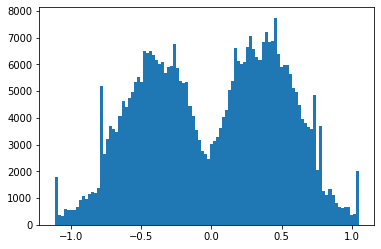

In [19]:
plt.hist(xsin.numpy().ravel(), bins=100 );

In [20]:
n_subsample = 32

In [21]:
xsin = xsin[0:n_subsample,...]

# static - evaluation, store activations at each layer

In [22]:
sc1 = model.conv1(xsin)
sc2 = model.conv2(sc1)
sp1 = model.pool1(sc2)
sd1 = model.dropout1(sp1)
sc3 = model.conv3(sd1)
sc4 = model.conv4(sc3)
sp2 = model.pool2(sc4)
sd2 = model.dropout2(sp2)
sfl = model.flatten(sd2)
sds1 = model.dense1(sfl)
sd3 = model.dropout3(sds1)
sds2 = model.dense2(sd3)

In [23]:
yh_static = model.predict(sds2, "static")

In [24]:
corr32s = (ys[0:n_subsample] == yh_static).numpy()

In [25]:
stata32 = tf.reduce_mean(tf.cast(ys[0:n_subsample] == yh_static, "float")).numpy()

# Dynamic - evaluation, store trains/activations at each layer

In [26]:
#lambda to convert phases to spike trains
p2t = lambda x: phase_to_train(x, input_shape, repeats=m_repeats)

In [27]:
#convert the sample images to spike trains
ssin = p2t(xsin)

In [28]:
#do a dynamic (temporal) call on the input spike trains
spks0 = model.conv1.call_dynamic(ssin, save_solutions = False)

100%|██████████| 32/32 [20:30<00:00, 38.44s/it]


In [29]:
#convert the first layer of output spikes to phases
phase0 = train_to_phase(spks0, model.conv1.output_shape2, depth=1, repeats=m_repeats)

In [30]:
#dtype casting lambda
fcast = lambda x: tf.cast(x, "float")

In [31]:
"""
Measure the MSE between values. Count NaN as maximum error possible (1.0).
"""
def nan_mse(x, y):
    x = x.numpy()
    y = y.numpy()
    
    nans = np.isnan(x)
    diffs = x - y
    diffs[nans] = 1.0
    return np.mean(np.power(diffs, 2.0))

In [32]:
nan_mse(phase0[0][0,...], sc1[0])

0.6416437486859564

In [33]:
nans1 = np.array([[np.sum(np.isnan(phase0[j][i,...])) for i in range(m_repeats)] for j in range(n_subsample)])

In [34]:
mse1s = np.array([[nan_mse(phase0[j][i,...], sc1[j]) for i in range(m_repeats)] for j in range(n_subsample)])

Text(0, 0.5, 'MSE')

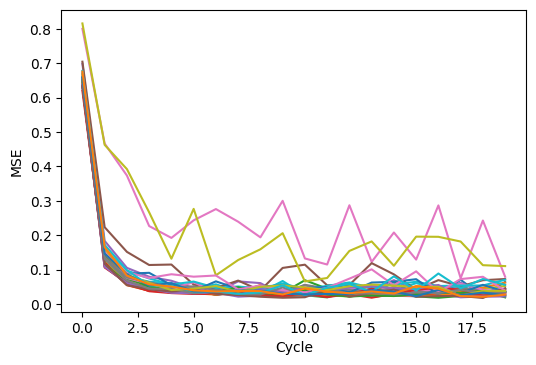

In [40]:
plt.figure(dpi=dpi)
plt.plot(mse1s.transpose());
plt.xlabel("Cycle")
plt.ylabel("MSE")

Text(0, 0.5, 'Total NaN (no spike)')

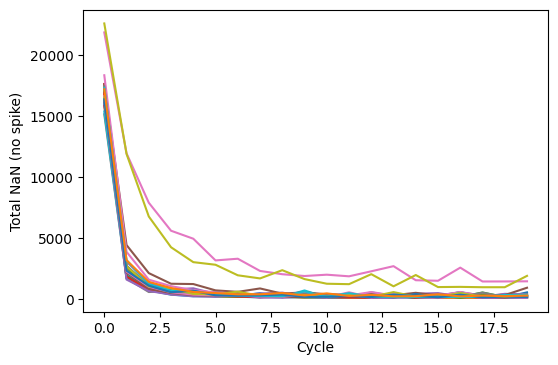

In [41]:
plt.figure(dpi=dpi)
plt.plot(nans1.transpose());
plt.xlabel("Cycle")
plt.ylabel("Total NaN (no spike)")

Text(0, 0.5, 'Atemporal Value')

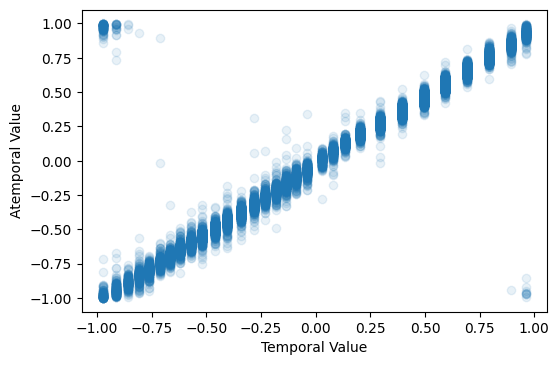

In [42]:
plt.figure(dpi=dpi)
plt.scatter(phase0[1][-1,...], sc1[1,...], alpha=0.1)
plt.xlabel("Temporal Value")
plt.ylabel("Atemporal Value")

In [43]:
spks1 = model.conv2.call_dynamic(spks0)

100%|██████████| 32/32 [10:58<00:00, 20.58s/it]


In [44]:
phase1 = train_to_phase(spks1, model.conv2.output_shape2, depth=2, repeats=m_repeats)

In [45]:
mse2s = np.array([[nan_mse(phase1[j][i,...], sc2[j]) for i in range(m_repeats)] for j in range(n_subsample)])

Text(0, 0.5, 'MSE')

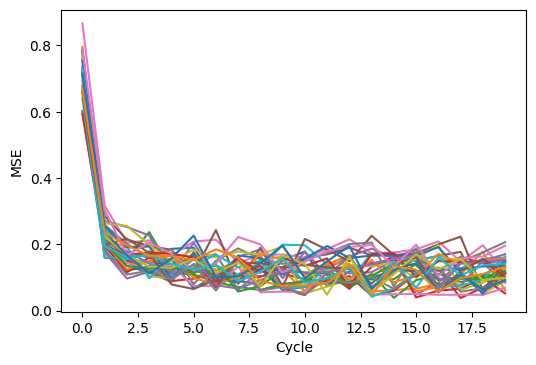

In [46]:
plt.figure(dpi=dpi)
plt.plot(mse2s.transpose());
plt.xlabel("Cycle")
plt.ylabel("MSE")

Text(0, 0.5, 'Atemporal Value')

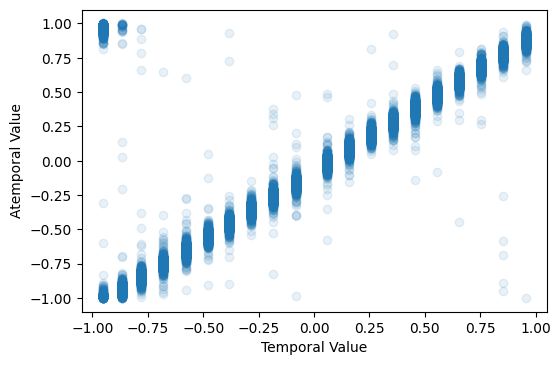

In [60]:
plt.figure(dpi=dpi)
plt.scatter(phase1[0][-1,...], sc2[0,...], alpha=0.1)
plt.xlabel("Temporal Value")
plt.ylabel("Atemporal Value")

In [48]:
poolin = model.conv2.output_shape2

In [49]:
poolout = model.pool_layer1.compute_output_shape([None, *poolin])[1:]

In [50]:
poolout

TensorShape([14, 14, 32])

In [51]:
spks2 = dynamic_minpool2D(spks1, poolin, (2,2), period=1.0, depth=2)

In [52]:
phase2 = train_to_phase(spks2, poolout, depth=2, repeats=m_repeats)

In [53]:
mse3s = np.array([[nan_mse(phase2[j][i,...], sp1[j]) for i in range(m_repeats)] for j in range(n_subsample)])

Text(0, 0.5, 'Atemporal Value')

<Figure size 600x400 with 0 Axes>

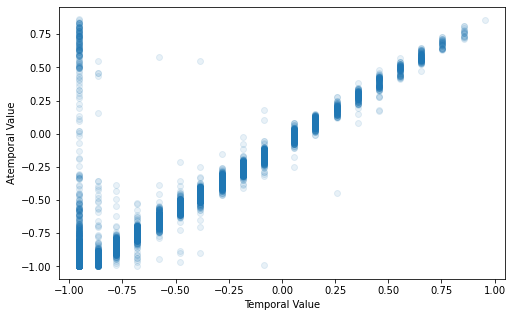

In [64]:
plt.figure(dpi=dpi)
plt.figure(figsize=(8,5))
plt.scatter(phase2[0][-1,...], sp1[0,...], alpha=0.1)
plt.xlabel("Temporal Value")
plt.ylabel("Atemporal Value")

Text(0, 0.5, 'MSE')

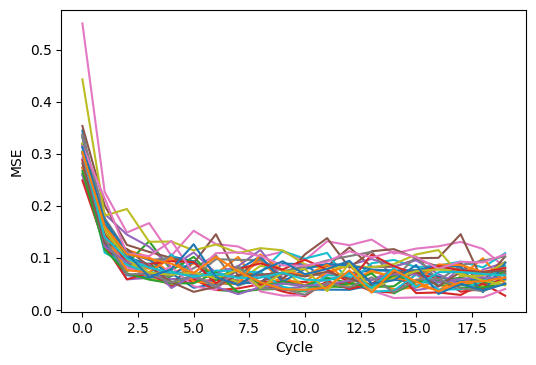

In [62]:
plt.figure(dpi=dpi)
plt.plot(mse3s.transpose());
plt.xlabel("Cycle")
plt.ylabel("MSE")

Text(0.5, 0, 'Time (s)')

<Figure size 600x400 with 0 Axes>

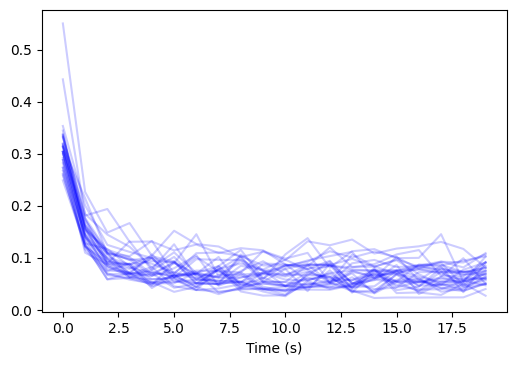

In [63]:
plt.figure(dpi=dpi)
plt.figure(dpi=dpi)
plt.plot(mse3s.transpose(), label="Min. Pool 1", color="blue", alpha=0.20);
plt.xlabel("Time (s)")

In [57]:
spks3 = model.conv3.call_dynamic(spks2)

100%|██████████| 32/32 [05:37<00:00, 10.55s/it]


In [67]:
phase3 = train_to_phase(spks3, model.conv3.output_shape2, depth=3, repeats=m_repeats)

In [68]:
mse4s = np.array([[nan_mse(phase3[j][i,...], sc3[j]) for i in range(m_repeats)] for j in range(n_subsample)])

<Figure size 600x400 with 0 Axes>

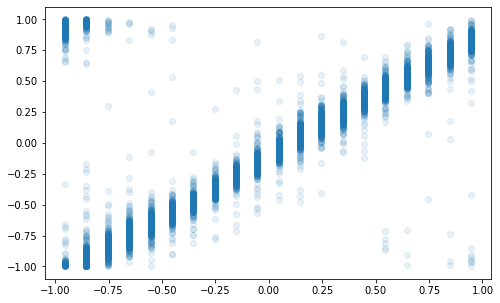

In [71]:
plt.figure(dpi=dpi)
plt.figure(figsize=(8,5))
plt.scatter(phase3[0][-2,...], sc3[0,...], alpha=0.1)

Text(0, 0.5, 'MSE')

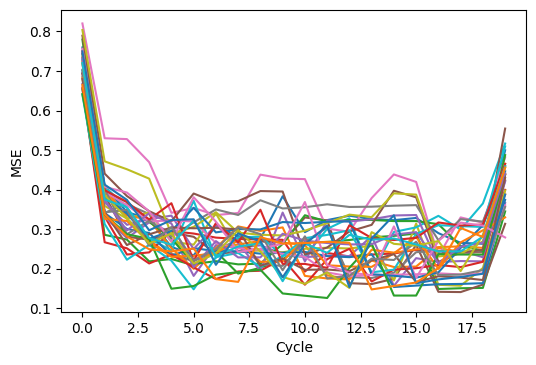

In [70]:
plt.figure(dpi=dpi)
plt.plot(mse4s.transpose());
plt.xlabel("Cycle")
plt.ylabel("MSE")

In [72]:
spks4 = model.conv4.call_dynamic(spks3)

100%|██████████| 32/32 [05:01<00:00,  9.42s/it]


In [73]:
phase4 = train_to_phase(spks4, model.conv4.output_shape2, depth=4, repeats=m_repeats)

In [74]:
mse5s = np.array([[nan_mse(phase4[j][i,...], sc4[j]) for i in range(m_repeats)] for j in range(n_subsample)])

Text(0, 0.5, 'Atemporal Value')

<Figure size 600x400 with 0 Axes>

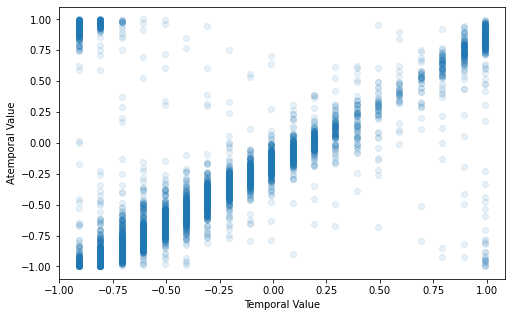

In [75]:
plt.figure(dpi=dpi)
plt.figure(figsize=(8,5))
plt.scatter(phase4[0][-2,...], sc4[0,...], alpha=0.1)
plt.xlabel("Temporal Value")
plt.ylabel("Atemporal Value")

Text(0, 0.5, 'MSE')

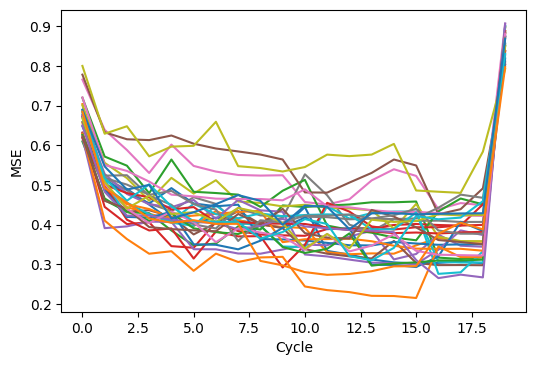

In [76]:
plt.figure(dpi=dpi)
plt.plot(mse5s.transpose());
plt.xlabel("Cycle")
plt.ylabel("MSE")

In [77]:
poolin2 = model.conv4.output_shape2

In [78]:
poolout2 = model.pool_layer2.compute_output_shape([None, *poolin2])[1:]

In [79]:
spks5 = dynamic_minpool2D(spks4, poolin2, (2,2), period=1.0, depth=4)

In [80]:
phase5 = train_to_phase(spks5, poolout2, depth=4, repeats=m_repeats)

In [81]:
mse6s = np.array([[nan_mse(phase5[j][i,...], sp2[j]) for i in range(m_repeats)] for j in range(n_subsample)])

Text(0, 0.5, 'Atemporal Value')

<Figure size 600x400 with 0 Axes>

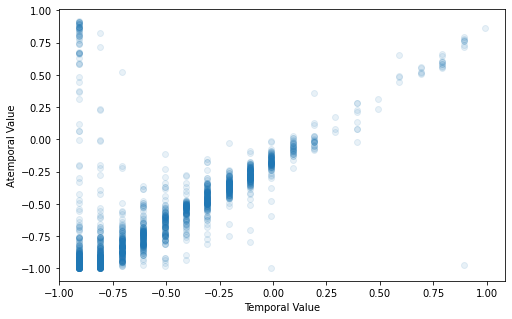

In [100]:
plt.figure(dpi=dpi)
plt.figure(figsize=(8,5))
plt.scatter(phase5[0][-2,...], sp2[0,...], alpha=0.1)
plt.xlabel("Temporal Value")
plt.ylabel("Atemporal Value")

Text(0, 0.5, 'MSE')

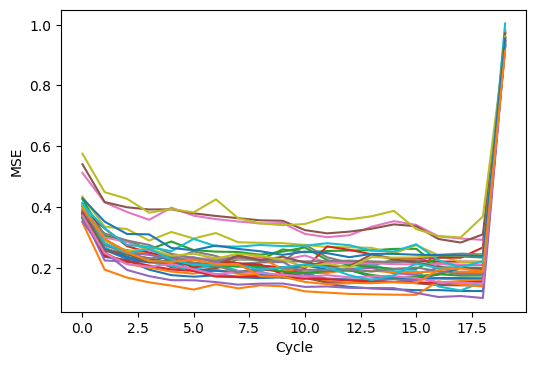

In [83]:
plt.figure(dpi=dpi)
plt.plot(mse6s.transpose());
plt.xlabel("Cycle")
plt.ylabel("MSE")

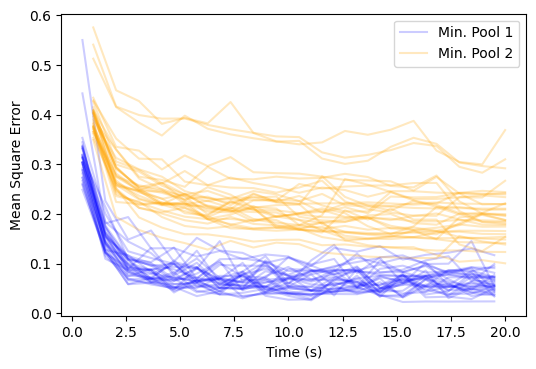

In [84]:
plt.figure(dpi=dpi)
plt.plot(0.5+np.linspace(0, 19, 19), mse3s[0:1,0:19].transpose(), label="Min. Pool 1", color="blue", alpha=0.20);
plt.plot(0.5+np.linspace(0, 19, 19), mse3s[1:,0:19].transpose(), color="blue", alpha=0.20);

plt.plot(1.0+np.linspace(0, 19, 19), mse6s[0:1,0:19].transpose(), label="Min. Pool 2", color="orange", alpha=0.25);
plt.plot(1.0+np.linspace(0, 19, 19), mse6s[1:,0:19].transpose(), color="orange", alpha=0.25);

plt.xlabel("Time (s)")
plt.ylabel("Mean Square Error")
plt.legend()

In [85]:
spks_flt = dynamic_flatten(spks5, input_shape=poolout2)

In [86]:
spks6 = model.dense1.call_dynamic(spks_flt)

100%|██████████| 32/32 [02:45<00:00,  5.17s/it]


In [87]:
phase6 = train_to_phase(spks6, model.dense1.output_shape2, depth=5, repeats=m_repeats)

In [88]:
mse7s = np.array([[nan_mse(phase6[j][i,...], sds1[j]) for i in range(m_repeats)] for j in range(n_subsample)])

Text(0, 0.5, 'MSE')

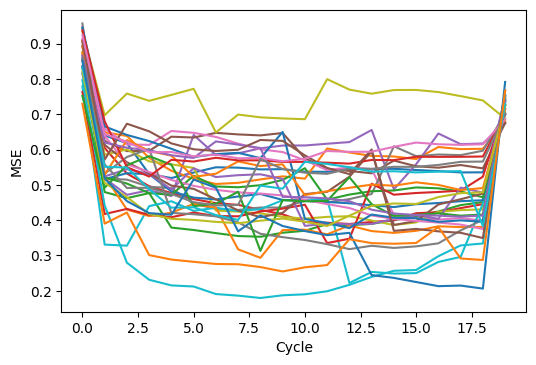

In [89]:
plt.figure(dpi=dpi)
plt.plot(mse7s.transpose());
plt.xlabel("Cycle")
plt.ylabel("MSE")

Text(0, 0.5, 'Atemporal Value')

<Figure size 600x400 with 0 Axes>

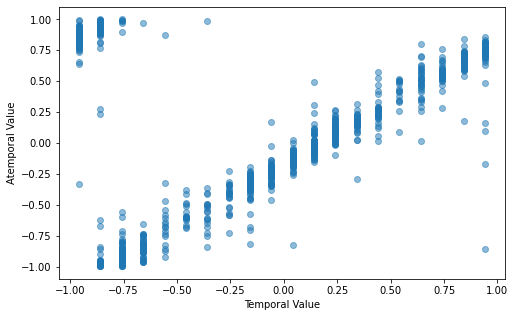

In [90]:
plt.figure(dpi=dpi)
plt.figure(figsize=(8,5))
plt.scatter(phase6[0][-2,:], sds1[0], alpha=0.5)
plt.xlabel("Temporal Value")
plt.ylabel("Atemporal Value")

In [91]:
model.dense2.input_shape2 = tf.constant([1000], dtype="int64")

In [92]:
spks7 = model.dense2.call_dynamic(spks6)

100%|██████████| 32/32 [02:06<00:00,  3.96s/it]


In [93]:
phase7 = train_to_phase(spks7, model.dense2.output_shape2, depth=6, repeats=m_repeats)

In [94]:
mse8s = np.array([[nan_mse(phase7[j][i,...], sds2[j]) for i in range(m_repeats)] for j in range(n_subsample)])

Text(0, 0.5, 'Atemporal Value')

<Figure size 600x400 with 0 Axes>

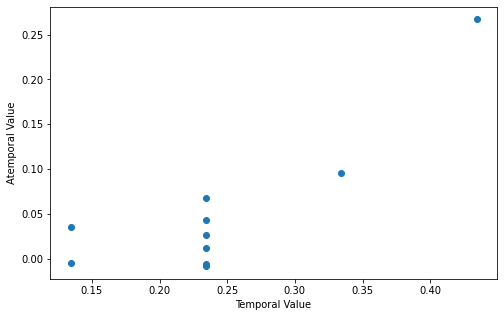

In [103]:
plt.figure(dpi=dpi)
plt.figure(figsize=(8,5))
plt.scatter(phase7[0][-2,:], sds2[0])
plt.xlabel("Temporal Value")
plt.ylabel("Atemporal Value")

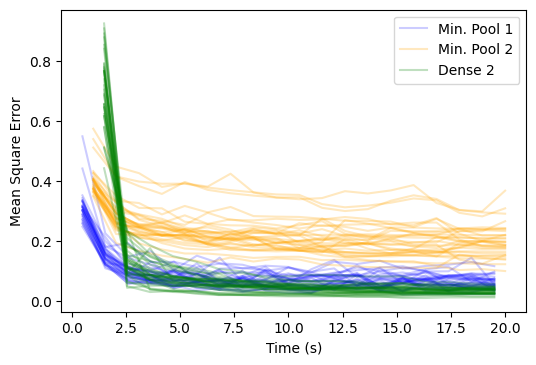

In [96]:
plt.figure(dpi=dpi)
plt.plot(0.5+np.linspace(0, 19, 19), mse3s[0:1,0:19].transpose(), label="Min. Pool 1", color="blue", alpha=0.20);
plt.plot(0.5+np.linspace(0, 19, 19), mse3s[1:,0:19].transpose(), color="blue", alpha=0.20);

plt.plot(1.0+np.linspace(0, 19, 19), mse6s[0:1,0:19].transpose(), label="Min. Pool 2", color="orange", alpha=0.25);
plt.plot(1.0+np.linspace(0, 19, 19), mse6s[1:,0:19].transpose(), color="orange", alpha=0.25);

plt.plot(1.5+np.linspace(0, 18, 18), mse8s[0:1,0:18].transpose(), label="Dense 2", color="green", alpha=0.25);
plt.plot(1.5+np.linspace(0, 18, 18), mse8s[1:,0:18].transpose(), color="green", alpha=0.25);

plt.xlabel("Time (s)")
plt.ylabel("Mean Square Error")
plt.legend()

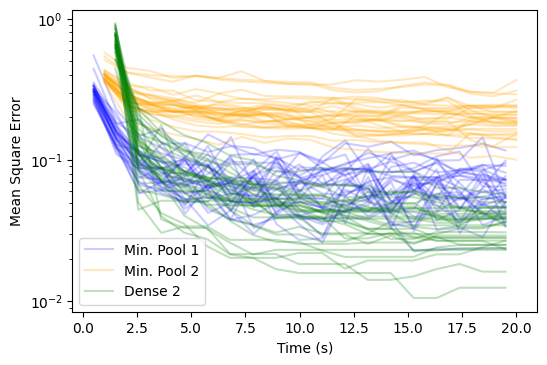

In [97]:
plt.figure(dpi=dpi)
plt.semilogy(0.5+np.linspace(0, 19, 19), mse3s[0:1,0:19].transpose(), label="Min. Pool 1", color="blue", alpha=0.20);
plt.semilogy(0.5+np.linspace(0, 19, 19), mse3s[1:,0:19].transpose(), color="blue", alpha=0.20);

plt.semilogy(1.0+np.linspace(0, 19, 19), mse6s[0:1,0:19].transpose(), label="Min. Pool 2", color="orange", alpha=0.25);
plt.semilogy(1.0+np.linspace(0, 19, 19), mse6s[1:,0:19].transpose(), color="orange", alpha=0.25);

plt.plot(1.5+np.linspace(0, 18, 18), mse8s[0:1,0:18].transpose(), label="Dense 2", color="green", alpha=0.25);
plt.plot(1.5+np.linspace(0, 18, 18), mse8s[1:,0:18].transpose(), color="green", alpha=0.25);

plt.xlabel("Time (s)")
plt.ylabel("Mean Square Error")
plt.legend()

In [98]:
trange = np.linspace(0.0, 20.0, 501)

In [102]:
cspks2 = [np.mean([np.sum(spks2[j][1] < t) for j in range(n_subsample)]) for t in trange]

In [104]:
cspks5 = [np.mean([np.sum(spks5[j][1] < t) for j in range(n_subsample)]) for t in trange]

In [105]:
cspks7 = [np.mean([np.sum(spks7[j][1] < t) for j in range(n_subsample)]) for t in trange]

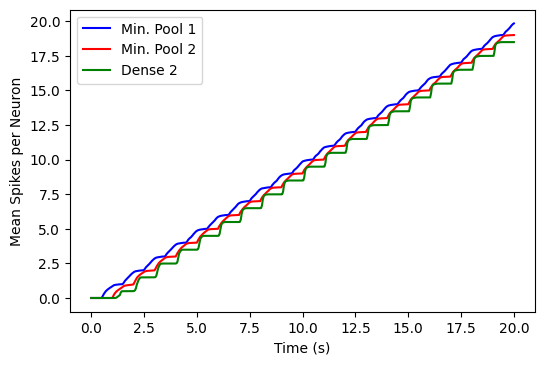

In [106]:
plt.figure(dpi=dpi)
plt.plot(trange,cspks2/np.prod((14,14,32)), label="Min. Pool 1", color="blue")
plt.plot(trange,cspks5/np.prod((5,5,64)), label="Min. Pool 2", color="red")
plt.plot(trange,cspks7/np.prod((10)), label="Dense 2", color="green")
plt.ylabel("Mean Spikes per Neuron")
plt.xlabel("Time (s)")
plt.legend()

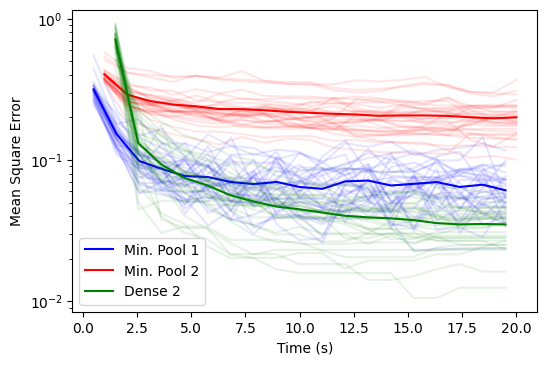

In [107]:
plt.figure(dpi=dpi)
plt.semilogy(0.5+np.linspace(0, 19, 19), np.mean(mse3s[:,0:19], axis=0).transpose(), label="Min. Pool 1", color="blue");
plt.semilogy(0.5+np.linspace(0, 19, 19), mse3s[:,0:19].transpose(), color="blue", alpha=0.10);

plt.semilogy(1.0+np.linspace(0, 19, 19), np.mean(mse6s[:,0:19], axis=0).transpose(), label="Min. Pool 2", color="red");
plt.semilogy(1.0+np.linspace(0, 19, 19), mse6s[:,0:19].transpose(), color="red", alpha=0.10);

plt.plot(1.5+np.linspace(0, 18, 18), np.mean(mse8s[:,0:18], axis=0).transpose(), label="Dense 2", color="green");
plt.plot(1.5+np.linspace(0, 18, 18), mse8s[:,0:18].transpose(), color="green", alpha=0.10);

plt.xlabel("Time (s)")
plt.ylabel("Mean Square Error")
plt.legend()

In [108]:
all_predictions = np.load("1024_dyn.npz")["a"]

In [110]:
p7ss = tf.stack(phase7, axis=0)

In [111]:
dyn_predictions = tf.stack([model._predict_ind(p7ss, j) for j in range(m_repeats)], axis=0)

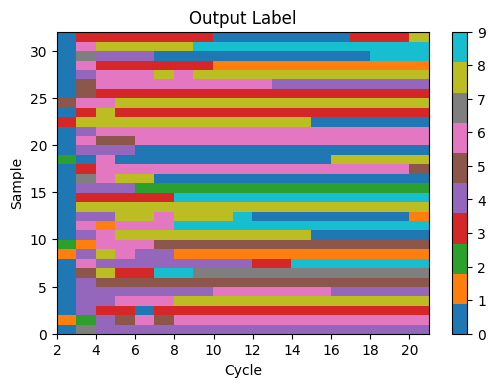

In [112]:
plt.figure(dpi=dpi)
plt.pcolor(dyn_predictions[0:m_repeats-1,:].numpy().transpose(), cmap="tab10")
plt.xticks(np.arange(0,m_repeats-1,2), np.arange(2,2+(m_repeats-1),2))
plt.xlabel("Cycle")
plt.ylabel("Sample")
plt.title("Output Label")
plt.colorbar()

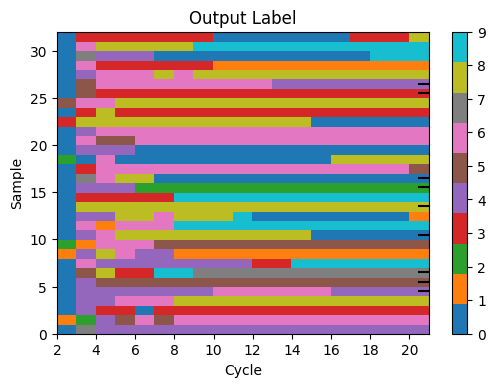

In [113]:
plt.figure(dpi=dpi)
plt.pcolor(dyn_predictions[0:19,:].numpy().transpose(), cmap="tab10")
plt.xticks(np.arange(0,19,2), np.arange(2,21,2))
for i in range(n_subsample):
    if not corr32s[i]:
        plt.plot((18.5,19.0), (i+0.5, i+0.5),"black")
plt.xlabel("Cycle")
plt.ylabel("Sample")
plt.title("Output Label")
plt.colorbar()

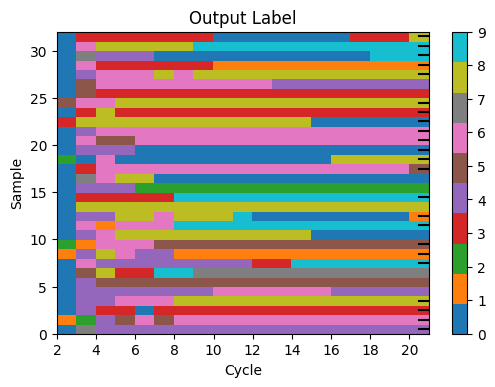

In [114]:
plt.figure(dpi=dpi)
plt.pcolor(dyn_predictions[0:19,:].numpy().transpose(), cmap="tab10")
plt.xticks(np.arange(0,19,2), np.arange(2,21,2))
for i in range(32):
    if corr32s[i]:
        plt.plot((18.5,19.0), (i+0.5, i+0.5),"black")
plt.xlabel("Cycle")
plt.ylabel("Sample")
plt.title("Output Label")
plt.colorbar()

In [115]:
yss = ys[0:32]

In [116]:
dyn_right = np.array([yss.numpy() == dyn_predictions[i,:].numpy() for i in range(20)])

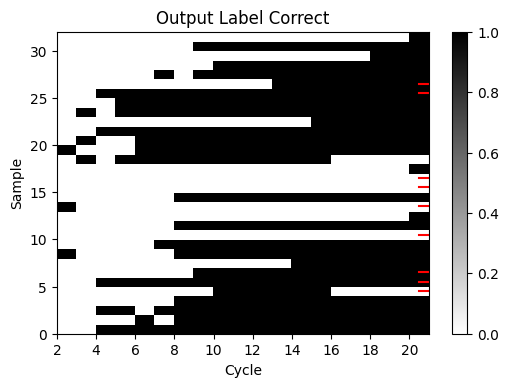

In [117]:
plt.figure(dpi=dpi)
plt.pcolor(dyn_right[0:19,:].transpose(), cmap="binary")
plt.xticks(np.arange(0,19,2), np.arange(2,21,2))
for i in range(32):
    if not corr32s[i]:
        plt.plot((18.5,19.0), (i+0.5, i+0.5),"red")
plt.xlabel("Cycle")
plt.ylabel("Sample")
plt.title("Output Label Correct")
plt.colorbar()

In [118]:
t_acc = [np.mean(yss.numpy() == dyn_predictions[i,:].numpy()) for i in range(20)]

In [119]:
n_correct = [np.sum(yss.numpy() == dyn_predictions[i,:].numpy()) for i in range(20)]

Text(0, 0.5, 'Accuracy')

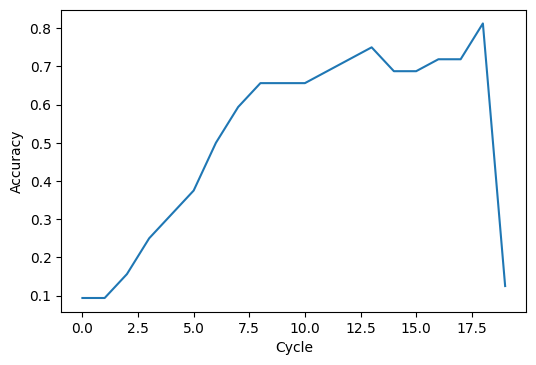

In [121]:
plt.figure(dpi=dpi)
plt.plot(t_acc)
plt.xlabel("Cycle")
plt.ylabel("Accuracy")